# Introduction 
* This code is adapted from the example provided in the python optimal transport package 

This notebook presents the results of mapping a 1D uniform and 2D uniform input distribution to a 2D uniform target distribution on a cylinder embedded in 3D.


## Imports

In [1]:
%matplotlib inline
%matplotlib widget
# import sys
# !{sys.executable} -m pip install pot
# !{sys.executable} -m pip install ipympl 
# !{sys.executable} -m pip install ipywidgets

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
from torch import nn
import ot
import scipy 

use_cuda = torch.cuda.is_available()
if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

seed = 126
torch.manual_seed(seed) # make chunk execution consistent 

__CUDNN VERSION: 8902
__Number CUDA Devices: 1
__CUDA Device Name: NVIDIA GeForce RTX 4080
__CUDA Device Total Memory [GB]: 16.860184576


## Data generation

In [2]:
torch.manual_seed(seed) # make chunk execution consistent 

sigma = 0.0
n_dims = 3
n_features = 1


def get_data_unif(n_samples):
    # c = torch.rand(size=(n_samples, 2))
    c1 = torch.arange(1, n_samples+1) / (n_samples)# .reshape((n_samples, 1)) / (n_samples)
    c2 = torch.arange(1, n_samples+1) / (n_samples)# .reshape((n_samples, 1)) / (n_samples)
    c = torch.cartesian_prod(c1,c2)
    x = c
    return x

def get_data(n_samples):
    u = torch.rand(size=(n_samples, 1))
    v = torch.rand(size=(n_samples, 1))
    u = u * np.pi
    v = v * 2 * np.pi
    # v = v * np.pi
    r = 1
    x = torch.cat((r*torch.sin(u)*torch.cos(v) , r*torch.sin(u)*torch.sin(v),r*torch.cos(u)), 1)
    # x += torch.randn(n_samples, 2) * sigma
    return x


def sample_surface_cylinder_torch(r, h, n_samples):
    # Points on the side surface
    phi = torch.rand(n_samples) * 2 * np.pi
    z_side = torch.rand(n_samples) * h
    x_side = r * torch.cos(phi)
    y_side = r * torch.sin(phi)
    
    # Combine side, top, and bottom surface points
    x = torch.cat([x_side]).unsqueeze(1)
    y = torch.cat([y_side]).unsqueeze(1)
    z = torch.cat([z_side]).unsqueeze(1)

    out = torch.cat((x, y, z), 1)
    return out

def sample_surface_cylinder_torch_2(r, h, n_samples):
    # sample uniform 
    # u = torch.rand(size=(n_samples, 1))
    # v = torch.rand(size=(n_samples, 1))
    c1 = torch.arange(1, n_samples+1) / (n_samples)# .reshape((n_samples, 1)) / (n_samples)
    c2 = torch.arange(1, n_samples+1) / (n_samples)# .reshape((n_samples, 1)) / (n_samples)
    c = torch.cartesian_prod(c1,c2)

    # convert to cylinder 
    x = r * torch.cos(2 * np.pi * c[:,0])
    y = r * torch.sin(2 * np.pi * c[:,0])
    z = c[:,1]

    out = torch.stack((x,y,z), 1)
    return out

def get_data_cylinder_sobol(n_samples, r=1):
    a = scipy.stats.qmc.Sobol(d=2, scramble=True, optimization='lloyd')
    c = torch.tensor(a.random_base2(m=n_samples)).float()

    # convert to cylinder 
    x = r * torch.cos(2 * np.pi * c[:,0])
    y = r * torch.sin(2 * np.pi * c[:,0])
    z = c[:,1]

    out = torch.stack((x,y,z), 1)
    return out


# empirical fill-based loss  
from scipy.spatial.distance import cdist
def fill_distance(data, fitted, type='max'): 
    m = torch.tensor(cdist(data, fitted, 'euclidean')) 
    # m = cdist(data, fitted, 'euclidean')
    min, min_indices = torch.min(m, dim=1) # min across rows 
    if type=='max':
        fill_dist = max(min)
    elif type=='mean':
        fill_dist = torch.mean(min)
    else:
        fill_dist = max(min)

    return fill_dist.item() # get actual float 


## Plot data



torch.Size([900, 3])


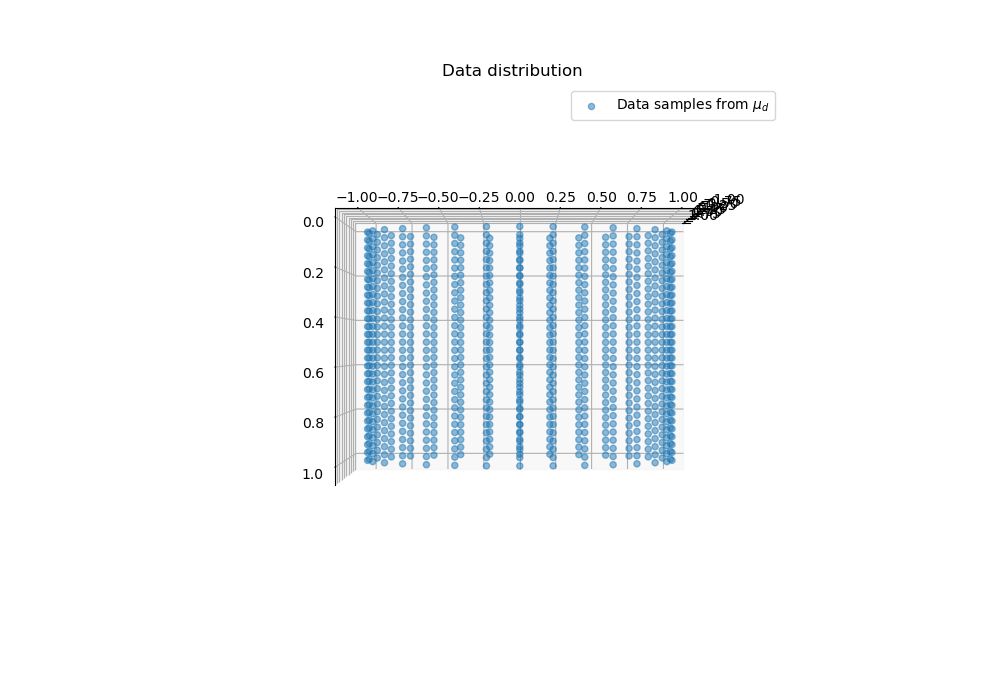

In [3]:
torch.manual_seed(seed) # make chunk execution consistent 

from mpl_toolkits import mplot3d

# plot the distributions
x =  sample_surface_cylinder_torch_2(r=1, h=1, n_samples=30)
# x = get_data_cylinder_sobol(n_samples=10, r=1)
print(x.shape)

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# Creating plot
plt.title("simple 3D scatter plot")
ax.scatter3D(x[:, 0], x[:, 1], x[:, 2], label='Data samples from $\mu_d$', alpha=0.5)
plt.title('Data distribution')
plt.legend()

ax.view_init(-180, 0)


## Generator Model



In [4]:
torch.manual_seed(seed) # make chunk execution consistent 

class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.n_features = 1
        self.n_out = 3
        leaky = 0.001
        w_layer = 250
        self.model = nn.Sequential( 
            nn.Linear(self.n_features, w_layer),
            nn.LeakyReLU(leaky),
            nn.Linear(w_layer, w_layer),
        )
        
        for i in range(0,5):
            temp = nn.Sequential(
                nn.Linear(w_layer, w_layer),
                nn.LeakyReLU(leaky),
            )
            self.model.append(temp)
            
        self.model.append(nn.Linear(w_layer, self.n_out))
        
    def forward(self, x):
        x = self.model(x)
        return x

g1 = Generator()
num_hidden_layers = sum(1 for _ in g1.modules() if isinstance(_, nn.Linear))
print(f"The number of hidden layers in G1 is: {num_hidden_layers}")


The number of hidden layers in G1 is: 8


## Training the model



Iter: 0, 	 wass-loss=1.35227, 	 fill-dist=1.15515
Iter: 10, 	 wass-loss=0.83288, 	 fill-dist=0.84422
Iter: 20, 	 wass-loss=0.60342, 	 fill-dist=0.71266
Iter: 30, 	 wass-loss=0.57507, 	 fill-dist=0.7004
Iter: 40, 	 wass-loss=0.30751, 	 fill-dist=0.50757


/home/hn/miniconda3/envs/wgan-self/lib/python3.11/site-packages/ot/lp/__init__.py:571: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


Iter: 50, 	 wass-loss=0.27901, 	 fill-dist=0.3288
Iter: 60, 	 wass-loss=0.19665, 	 fill-dist=0.31486
Iter: 70, 	 wass-loss=0.10663, 	 fill-dist=0.27578
Iter: 80, 	 wass-loss=0.12574, 	 fill-dist=0.28206
Iter: 90, 	 wass-loss=0.10049, 	 fill-dist=0.27199
Iter: 100, 	 wass-loss=0.11856, 	 fill-dist=0.27649
Iter: 110, 	 wass-loss=0.10872, 	 fill-dist=0.27406
Iter: 120, 	 wass-loss=0.09657, 	 fill-dist=0.25549
Iter: 130, 	 wass-loss=0.09021, 	 fill-dist=0.25975
Iter: 140, 	 wass-loss=0.08735, 	 fill-dist=0.25179
Iter: 150, 	 wass-loss=0.08678, 	 fill-dist=0.25053
Iter: 160, 	 wass-loss=0.07937, 	 fill-dist=0.23891
Iter: 170, 	 wass-loss=0.07398, 	 fill-dist=0.23053
Iter: 180, 	 wass-loss=0.07502, 	 fill-dist=0.23214
Iter: 190, 	 wass-loss=0.0717, 	 fill-dist=0.22185
Iter: 200, 	 wass-loss=0.06843, 	 fill-dist=0.22161
Iter: 210, 	 wass-loss=0.06634, 	 fill-dist=0.21581
Iter: 220, 	 wass-loss=0.06537, 	 fill-dist=0.20885
Iter: 230, 	 wass-loss=0.06026, 	 fill-dist=0.2045
Iter: 240, 	 wass-lo

Text(0.5, 0, 'Iterations')

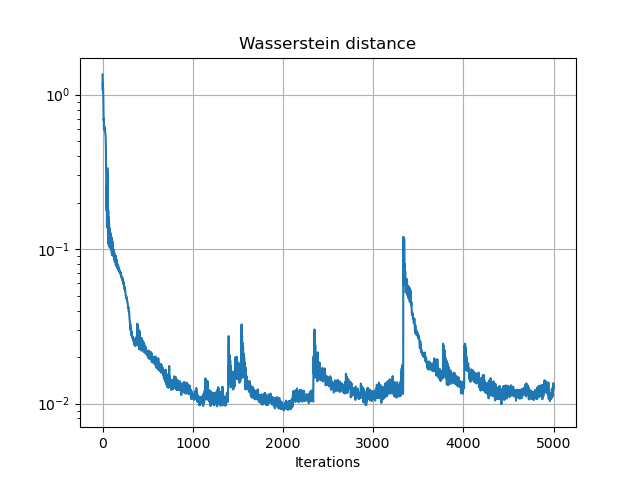

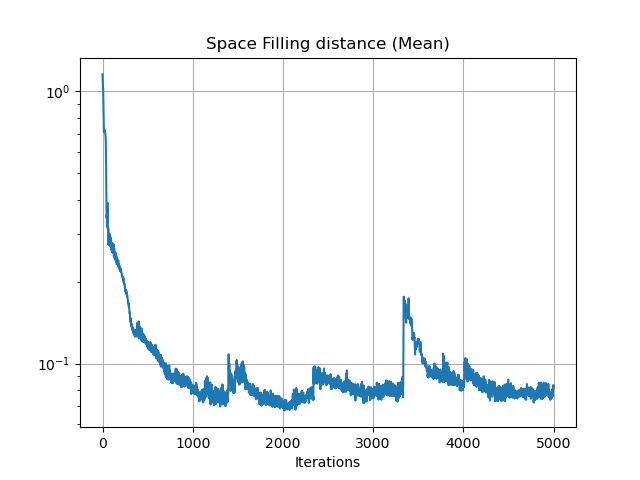

In [5]:
torch.manual_seed(seed) # make chunk execution consistent 

G = Generator()
optimizer = torch.optim.RMSprop(G.parameters(), lr=0.00019, eps=1e-5)

# number of iteration and size of the batches
n_iter = 5000 # 750
size_batch = 33 # 750

# generate static samples to see their trajectory along training
n_visu = size_batch**2
xnvisu = torch.rand(n_visu, n_features)
xvisu = torch.zeros(n_iter, n_visu, n_dims)

ab = torch.ones(size_batch**2) / size_batch**2
losses = []
fill_losses = []

xd =  sample_surface_cylinder_torch_2(r=1, h=1, n_samples=size_batch)

for i in range(n_iter):

    # generate noise samples
    # xn = torch.rand(size_batch**2, n_features)
    xn = torch.arange(1, size_batch**2+1).reshape((size_batch**2, n_features)) / (size_batch**2)

    # generate data samples
    # xd = get_data(size_batch)
    # generated above for this example 

    # generate sample along iterations
    xvisu[i, :, :] = G(xnvisu).detach()

    # generate samples and compute distance matrix
    xg = G(xn)
    M = ot.dist(xg, xd)
    loss = ot.emd2(ab, ab, M)
    losses.append(float(loss.detach()))

    fill_loss = fill_distance(xd.detach().numpy(), xg.detach().numpy(), type='mean')
    fill_losses.append(fill_loss)

    if i % 10 == 0:
        # print("Iter: {:3d}, loss={}".format(i, losses[-1]))
        print(f"Iter: {i}, \t wass-loss={round(losses[-1], 5)}, \t fill-dist={round(fill_loss, 5)}")

    loss.backward()
    optimizer.step()

    del M

# wasserstein loss 
plt.figure(2)
plt.semilogy(losses)
plt.grid()
plt.title('Wasserstein distance')
plt.xlabel("Iterations")

# fill distance 
plt.figure(3)
plt.semilogy(fill_losses)
plt.grid()
plt.title('Space Filling distance (Mean)')
plt.xlabel("Iterations")


## Plot trajectories of generated samples along iterations



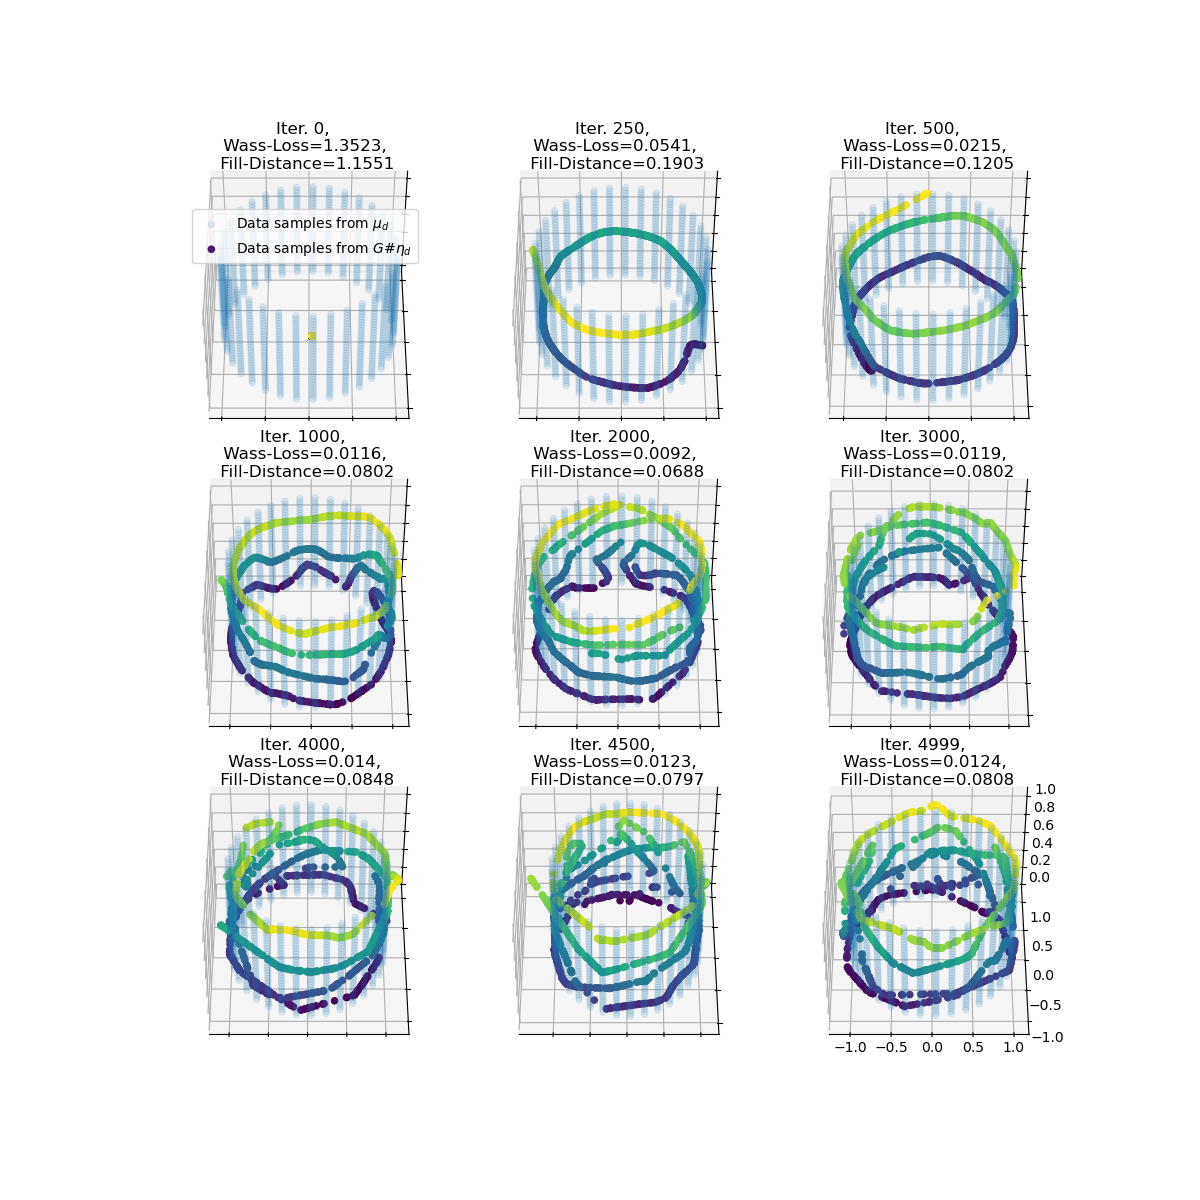

In [6]:
torch.manual_seed(seed) # make chunk execution consistent 

plt.clf()
plt.close('all')
# ivisu = [0, 10, 25, 50, 75, 100, 250, n_iter-500, n_iter-1]
ivisu = [0, 250, 500, 1000, 2000, 3000, 4000, n_iter-500, n_iter-1]


# create a figure and a 3x3 subplot grid
fig, axs = plt.subplots(3, 3, figsize=(12, 12), subplot_kw={'projection': '3d'}, edgecolor='none')
# fig.tight_layout(pad=1.0)

# iterate over each subplot to convert it into 3D and plot
for i, ax in enumerate(axs.flat):

    # convert subplot to 3D ---> no need, alr defined above 
        # ax = fig.add_subplot(3, 3, i+1, projection= '3d')

    # adjust the spacing between plots
    plt.subplots_adjust(wspace=-.3, hspace=-.1)
    
    # plot the data
    ax.scatter3D(xd[:, 0], xd[:, 1], xd[:, 2], label='Data samples from $\mu_d$', alpha=0.1)

        # calculate the distance of each point from the origin (0, 0)
    distances = xvisu[ivisu[i], :, 2]

        # use the distances to map to colors
    colors = distances

    ax.scatter3D(xvisu[ivisu[i], :, 0], xvisu[ivisu[i], :, 1], xvisu[ivisu[i], :, 2],
                 label='Data samples from $G\#\eta_d$', 
                 alpha=1,
                 c = distances, 
                 cmap = 'viridis'
                 )
    
    # set the view 
    ax.view_init(48, -90, 0) # 44, -90, 0

    # set titles and labels, see issue https://github.com/matplotlib/matplotlib/issues/16805/
    ax.set_title(f'Iter. {ivisu[i]}, \n Wass-Loss={round(losses[ivisu[i]], 4)}, \n Fill-Distance={round(fill_losses[ivisu[i]], 4)}', pad=0, y=1.000001) # need the 1.00001 to turn off auto 
        #ax.set_xlabel('X axis')
        #ax.set_ylabel('Y axis')
        #ax.set_zlabel('Z axis')
    if i == 0:
        ax.legend(bbox_to_anchor=(.5, .7), loc='center', borderaxespad=0) # bbox in coordinates 
    
     # hide the axis ticks
    if (i != 8): # only keep labels on third figure of each row 
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
    if (i == 8): # readjust x axis to be closer 
        ax.xaxis.set_tick_params(pad=-5)
    
    # adjust the visibility of the axes spines
        #ax.spines['top'].set_visible(False)
        #ax.spines['right'].set_visible(False)

# adjust the spacing
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.0)

plt.show()



## 2D to 2D

In [7]:
torch.manual_seed(seed) # make chunk execution consistent 

class Generator_2D_2D(torch.nn.Module):
    def __init__(self):
        super(Generator_2D_2D, self).__init__()
        self.n_features = 2
        self.n_out = 3
        leaky = 0.0001
        w_layer = 25
        self.model = nn.Sequential( 
            nn.Linear(self.n_features, w_layer),
            nn.LeakyReLU(leaky),
            nn.Linear(w_layer, w_layer),
        )
        
        for i in range(0,1):
            temp = nn.Sequential(
                nn.Linear(w_layer, w_layer),
                nn.LeakyReLU(leaky),
            )
            self.model.append(temp)
            
        self.model.append(nn.Linear(w_layer, self.n_out))
        
    def forward(self, x):
        x = self.model(x)
        return x
    

g2 = Generator_2D_2D()
num_hidden_layers = sum(1 for _ in g2.modules() if isinstance(_, nn.Linear))
print(f"The number of hidden layers in G2 is: {num_hidden_layers}")


The number of hidden layers in G2 is: 4


Iter: 0, 	 wass-loss=1.30692, 	 fill-dist=1.09969
Iter: 10, 	 wass-loss=1.10834, 	 fill-dist=1.01433
Iter: 20, 	 wass-loss=1.01203, 	 fill-dist=0.96923
Iter: 30, 	 wass-loss=0.94673, 	 fill-dist=0.93697
Iter: 40, 	 wass-loss=0.90224, 	 fill-dist=0.91031
Iter: 50, 	 wass-loss=0.8635, 	 fill-dist=0.88331
Iter: 60, 	 wass-loss=0.82587, 	 fill-dist=0.85524
Iter: 70, 	 wass-loss=0.78494, 	 fill-dist=0.82555
Iter: 80, 	 wass-loss=0.74127, 	 fill-dist=0.79528
Iter: 90, 	 wass-loss=0.6981, 	 fill-dist=0.76569
Iter: 100, 	 wass-loss=0.65874, 	 fill-dist=0.73907
Iter: 110, 	 wass-loss=0.6253, 	 fill-dist=0.71662
Iter: 120, 	 wass-loss=0.59693, 	 fill-dist=0.69739
Iter: 130, 	 wass-loss=0.57268, 	 fill-dist=0.68173
Iter: 140, 	 wass-loss=0.55302, 	 fill-dist=0.67036
Iter: 150, 	 wass-loss=0.53866, 	 fill-dist=0.66324
Iter: 160, 	 wass-loss=0.52997, 	 fill-dist=0.65725
Iter: 170, 	 wass-loss=0.52664, 	 fill-dist=0.6515
Iter: 180, 	 wass-loss=0.52761, 	 fill-dist=0.64557
Iter: 190, 	 wass-loss=0.53

Text(0.5, 0, 'Iterations')

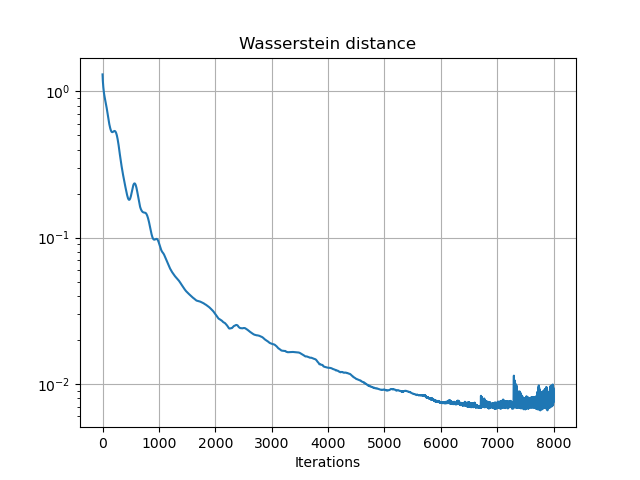

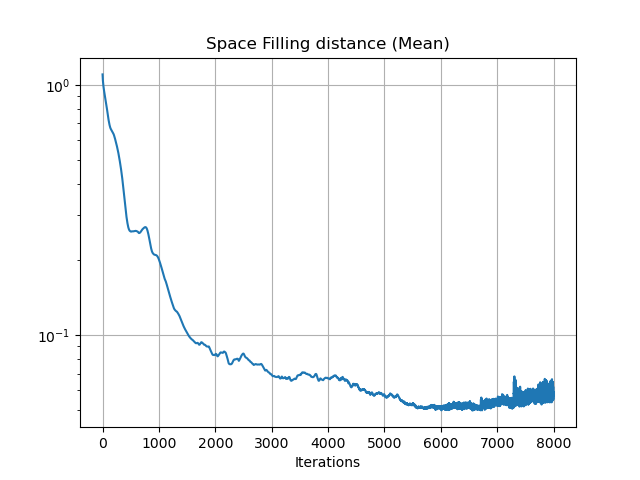

In [8]:
torch.manual_seed(seed) # make chunk execution consistent 
n_features=2

G = Generator_2D_2D()
optimizer = torch.optim.RMSprop(G.parameters(), lr=0.00019, eps=1e-5)

# number of iteration and size of the batches
n_iter = 8000 
size_batch = 30 

# generate static samples to see their trajectory along training
n_visu = size_batch**2
xnvisu = torch.rand(n_visu, n_features)
xvisu = torch.zeros(n_iter, n_visu, n_dims)
ab = torch.ones(size_batch**2) / size_batch**2
losses = []
fill_losses = []

xd =  sample_surface_cylinder_torch_2(r=1, h=1, n_samples=size_batch)

for i in range(n_iter):

    # generate noise samples
    # xn = torch.rand(size_batch**2, n_features)
    xn = get_data_unif(n_samples=size_batch)
    
    # generate data samples
    # xd = get_data(size_batch)
    # above for this example 

    # generate sample along iterations
    xvisu[i, :, :] = G(xnvisu).detach()

    # generate samples and compute distance matrix
    xg = G(xn)
    
    M = ot.dist(xg, xd)
    loss = ot.emd2(ab, ab, M)
    losses.append(float(loss.detach()))

    fill_loss = fill_distance(xd.detach().numpy(), xg.detach().numpy(), type='mean')
    fill_losses.append(fill_loss)

    if i % 10 == 0:
        print(f"Iter: {i}, \t wass-loss={round(losses[-1], 5)}, \t fill-dist={round(fill_loss, 5)}")

    loss.backward()
    optimizer.step()

    del M

# wasserstein loss 
plt.figure(2)
plt.semilogy(losses)
plt.grid()
plt.title('Wasserstein distance')
plt.xlabel("Iterations")

# fill distance 
plt.figure(3)
plt.semilogy(fill_losses)
plt.grid()
plt.title('Space Filling distance (Mean)')
plt.xlabel("Iterations")


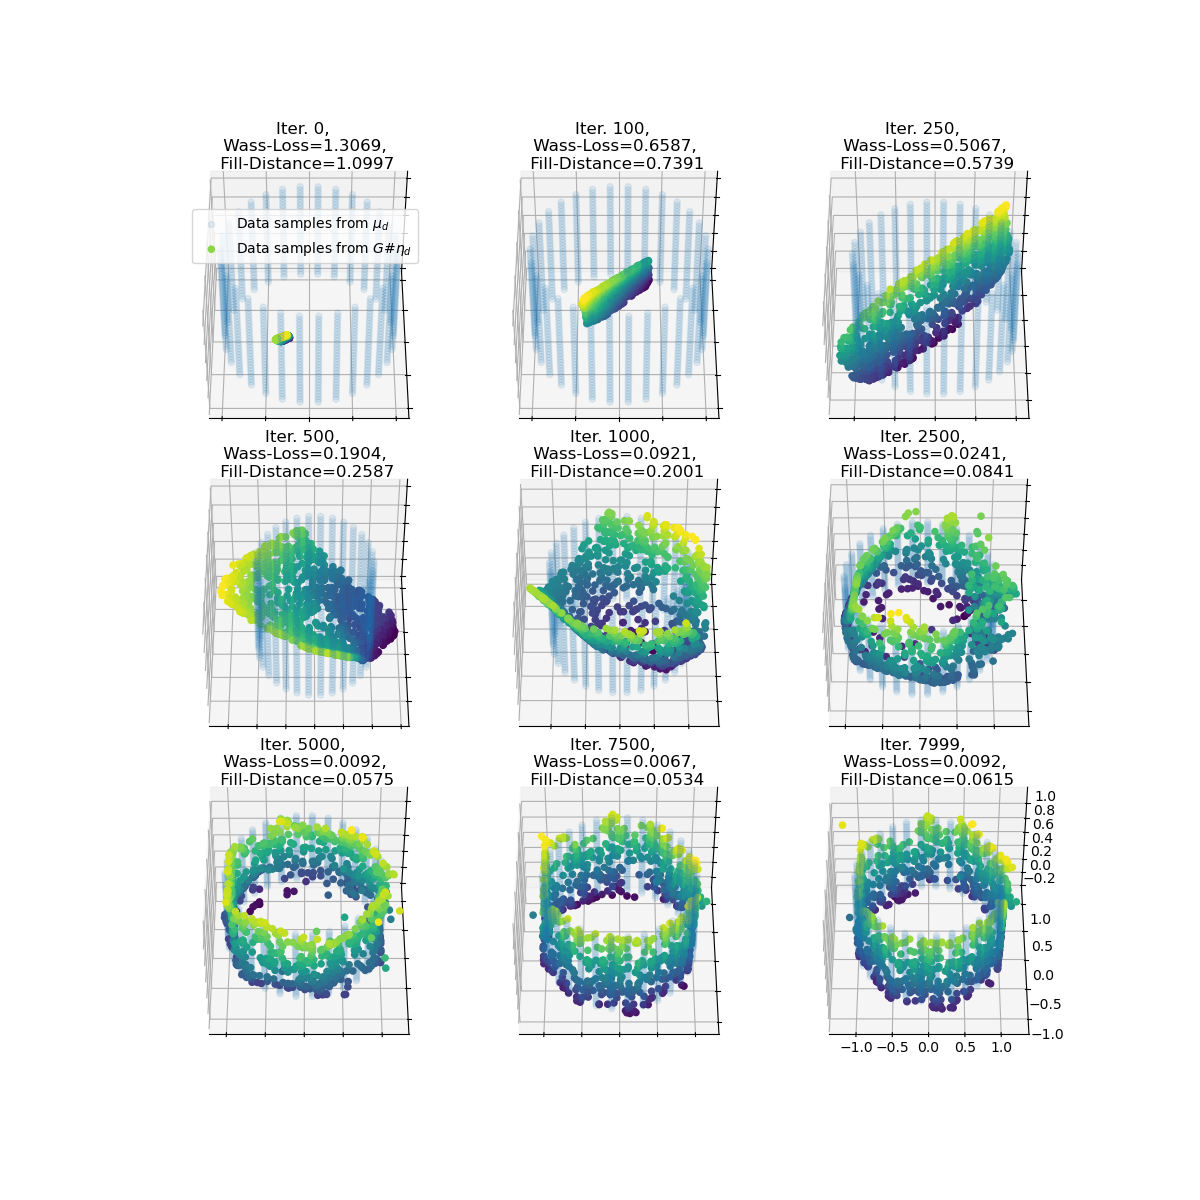

In [9]:
torch.manual_seed(seed) # make chunk execution consistent 

plt.clf()
plt.close('all')
# ivisu = [0, 50, 100, 500, n_iter-4000, n_iter-2500, n_iter-1000, n_iter-500, n_iter-1]
ivisu = [0, 100, 250, 500, 1000, 2500, 5000, 7500, n_iter-1]

# create a figure and a 3x3 subplot grid
fig, axs = plt.subplots(3, 3, figsize=(12, 12), subplot_kw={'projection': '3d'}, edgecolor='none')
# fig.tight_layout(pad=1.0)

# iterate over each subplot to convert it into 3D and plot 
for i, ax in enumerate(axs.flat):

    # convert subplot to 3D ---> no need, alr defined above 
        # ax = fig.add_subplot(3, 3, i+1, projection= '3d')

    # adjust the spacing between plots
    plt.subplots_adjust(wspace=-.3, hspace=-.1)
    
    # plot the data
    ax.scatter3D(xd[:, 0], xd[:, 1], xd[:, 2], label='Data samples from $\mu_d$', alpha=0.1)

    # calculate the distance of each point from the origin (0, 0)
    distances = xvisu[ivisu[i], :, 2]
    colors = distances  # use the distances to map to colors

    ax.scatter3D(xvisu[ivisu[i], :, 0], xvisu[ivisu[i], :, 1], xvisu[ivisu[i], :, 2],
                 label='Data samples from $G\#\eta_d$', 
                 alpha=1,
                 c = distances, 
                 cmap = 'viridis'
                 )
    
    # set the view 
    ax.view_init(48, -90, 0) # 44, -90, 0

    # set titles and labels, see issue https://github.com/matplotlib/matplotlib/issues/16805/
    ax.set_title(f'Iter. {ivisu[i]}, \n Wass-Loss={round(losses[ivisu[i]], 4)}, \n Fill-Distance={round(fill_losses[ivisu[i]], 4)}', pad=0, y=1.000001) # need the 1.00001 to turn off auto 
        #ax.set_xlabel('X axis')
        #ax.set_ylabel('Y axis')
        #ax.set_zlabel('Z axis')
    if i == 0:
        ax.legend(bbox_to_anchor=(.5, .7), loc='center', borderaxespad=0) # bbox in coordinates 
    
     # hide the axis ticks
    if (i != 8): # only keep labels on third figure of each row 
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
    if (i == 8): # readjust x axis to be closer 
        ax.xaxis.set_tick_params(pad=-5)
    
    # adjust the visibility of the axes spines
        #ax.spines['top'].set_visible(False)
        #ax.spines['right'].set_visible(False)

# adjust the spacing
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.0)
plt.show()

